# Lezione 07

## Dario Pullia

Ci proponiamo di completare il programma della lezione 4 in modo tale che possa simulare un sistema termodinamico NVT. 

Scegliamo di farlo implementando l'algoritmo di Metropolis. 
Ogni passo proposto è estratto in modo uniforme intorno alla particella selezionata, la cui lunghezza è legata al rapporto $\frac{N_{acc}}{N_{Tot}}$ e quindi all'efficienza dell'algoritmo. Per ogni stato il valore del passo è stato modificato manualmente affinchè $\frac{N_{acc}}{N_{Tot}} \sim 0.5$.
Il passo viene accettato con una probabilità $A(\nu|\mu)=min \left [1, \frac{p(\nu)}{p(\mu)} \right ]=min \left [1, {e^{-\beta \Delta E}} \right ]$. 

Introduciamo inoltre nella simulazione le **tail corrections** all'energia e alla pressione per all'errore ottenuto dall'uso del cut-off:
$$U_{tail}=8 N_{part} \pi \rho (\frac{r_{cut}^{-9}}{9}-\frac{r_{cut}^{-3}}{3})$$

$$P_{tail}=32 \frac{N_{part}}{V} \pi \rho (\frac{r_{cut}^{-9}}{9}-\frac{r_{cut}^{-3}}{6})$$

Studiamo i seguenti stati termodinamici:
- Fase solida: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- Fase liquida: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- Fase gassosa: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

Se nella lezione 4 si è reso necessario effettuare una modifica alla temperatura di input affinchè la temperatura target corrispondesse a quella desiderata, in questo caso non è necessario poichè il **sistema è di tipo NVT e pertanto conserva la temperatura**. Se la nostra richiesta fosse stata per qualche motivo l'energia totale, allora la procedura sarebbe stata necessaria.

#### Equilibrazione

Equilibriamo il sistema a partire da una struttura perfettamente cristallina. La procedura è eseguita usando blocchi da 1 passo, in modo da osservare la singola variazione.

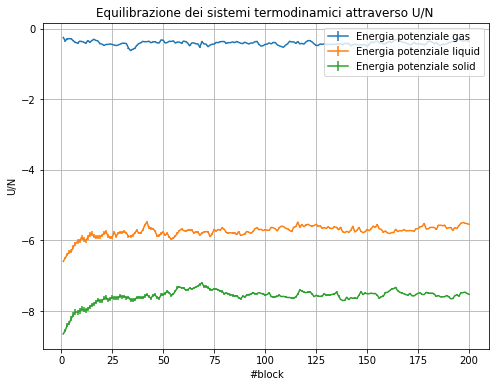

In [104]:
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np

npart=108


def DataBlocking(Epot, L):
    M=x[-1]
    N=int(M/L)
    E=0
    E2=0
    res=[]
    resErr=[]

    for i in range(N):
        Sum=0
        for j in range (L):
            Sum+=Epot[j+i*L]
        E=(Sum/L + E*i)/(i+1)
        E2=((Sum/L)**2 +E2*i)/(i+1)

    return error_prog(E, E2, N)


def error_prog( AV,  AV2,  n):
    if (n==0):
        return 0
    else:
        return math.sqrt((AV2-AV*AV)/n)


def AutoC(t, vec):
    appo1=0
    appo2=0
    appo3=0
    appo4=0
    appo5=0
    tmax=0
    tmax=vec.size
    for i in range(tmax-t):
        appo1+=vec[i]*vec[i+t]
        appo2+=vec[i]
        appo3+=vec[i+t]
    for i in range(tmax):
        appo4+=vec[i]*vec[i]
        appo5+=vec[i]
        
    return (appo1/(tmax-t) - appo2*appo3/((tmax-t)*(tmax-t)))/((appo4/tmax)-(appo5/tmax)**2)    






fig=plt.figure(figsize=(8, 6))

for s in ['gas','liquid','solid']:
    x, Epot, EpotAVG, EpotErr= np.loadtxt("dataeq/"+s+"/output_epot.dat", usecols=(0,1,2,3), delimiter=' ', unpack='true')

    plt.errorbar(x,Epot, yerr=EpotErr, marker="", label="Energia potenziale "+s)


plt.title('Equilibrazione dei sistemi termodinamici attraverso U/N ')
plt.xlabel('#block')
plt.ylabel('U/N')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

Osserviamo che dopo 50 passi il sistema è equilibrato.

### Esercizio 07.2

Usando le configurazioni finali ottenute dall'equilibrazione come input, evolviamo il sistema per $M=5 \cdot10^5$ passi in blocchi di lunghezza L=1.

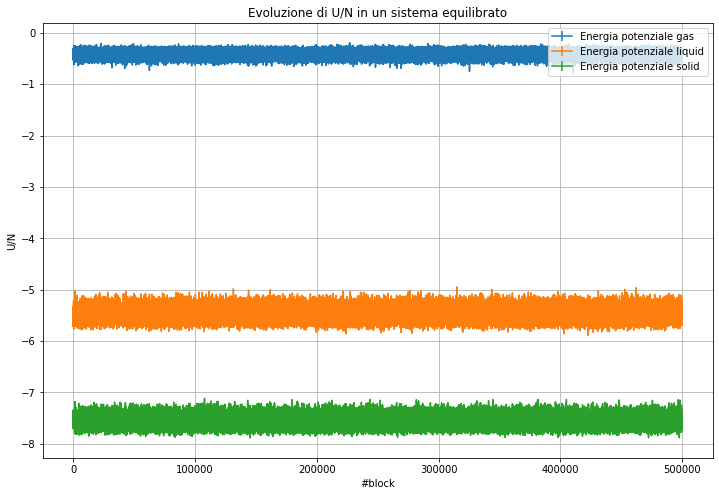

In [105]:

fig=plt.figure(figsize=(12,8))

for s in ['gas','liquid','solid']:
    x, Epot, EpotAVG, EpotErr= np.loadtxt("data02/"+s+"/output_epot.dat", usecols=(0,1,2,3), delimiter=' ', unpack='true')

    plt.errorbar(x,Epot, yerr=EpotErr, marker="", label="Energia potenziale "+s)


plt.title("Evoluzione di U/N in un sistema equilibrato")
plt.xlabel('#block')
plt.ylabel('U/N')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

Utilizziamo ora questi dati per misurare l'autocorrelazione del sistema, in modo da poter scegliere la dimensione dei blocchi affinchè questi siano scorrelati.

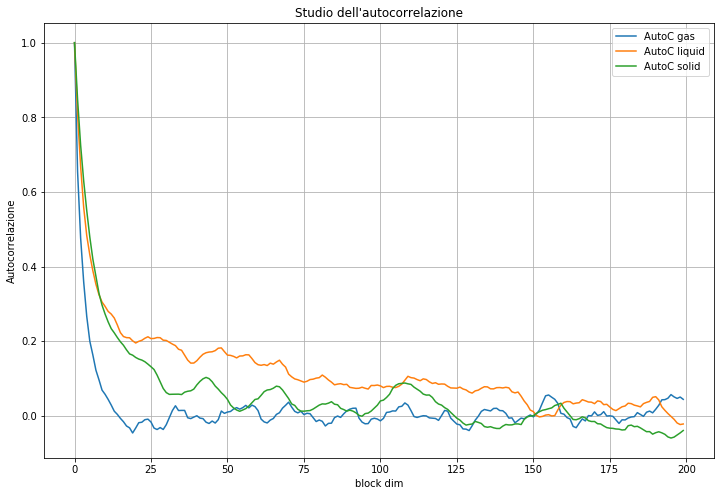

In [106]:
fig=plt.figure(figsize=(12,8))

for s in ['gas','liquid','solid']:
    Epot = np.loadtxt("data02/"+s+"/output_epot.dat", usecols=(1), delimiter=' ', unpack='true')

    ACor=[]

    for i in range(200):

        ACor.append(AutoC(i, Epot[:5000])) #Autocorrelare oltre i primi 5000 appesantisce inutilmente
        
    plt.plot(np.arange(200),ACor, label='AutoC '+s)

    


plt.title("Studio dell'autocorrelazione")   
plt.xlabel('block dim')
plt.ylabel('Autocorrelazione')
plt.grid(True)
plt.legend()
plt.show()

Notiamo che dopo $\sim 75$ passi le misure sono tra loro scorrelate.

Di seguito studiamo l'andamento dell'errore ottenuto facendo data-blocking con diverse dimensione dei blocchi.

[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5, 5, 6, 6, 7, 8, 8, 9, 10, 11, 12, 13, 15, 16, 18, 19, 21, 23, 26, 28, 31, 34, 37, 41, 45, 49, 54, 59, 65, 71, 77, 85, 93, 102, 112, 122, 134, 147, 161, 176, 193, 211, 231, 253, 277, 304, 333, 364, 399, 437, 478, 524, 574, 628, 688, 753, 825, 903, 989, 1083, 1186, 1299, 1422, 1557, 1705, 1867, 2045, 2239, 2452, 2685, 2940, 3220, 3525, 3860, 4227, 4629, 5069, 5550, 6077, 6655, 7287, 7979]


<Figure size 864x576 with 0 Axes>

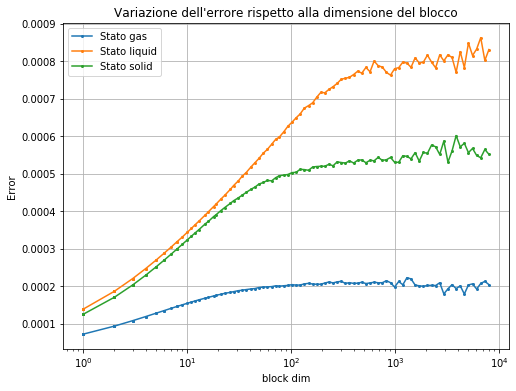

In [107]:
fig=plt.figure(figsize=(12,8))

#L=[10,20,30,50,70,100,150, 200,250, 300,350, 400,500, 600,700,800,900,1000,1250,1500,1750,2000,2250,2500,2750,3000,3500,4000,4500,5000]
L=[]
for i in range(100):
    L.append(int(pow(1.095,i)))
print(L)
fig=plt.figure(figsize=(8, 6))

for s in ['gas','liquid','solid']:
    Epot= np.loadtxt("data02/"+s+"/output_epot.dat", usecols=(1), delimiter=' ', unpack='true')

    Errors=[]
    for i in L:
        Errors.append(DataBlocking(Epot, i))
    plt.plot(L,Errors, marker="o", markersize=2,label='Stato '+s)
    

plt.title("Variazione dell'errore rispetto alla dimensione del blocco")   
plt.xlabel('block dim')
plt.ylabel('Error')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()  

Osserviamo che per blocchi di dimensione inferiore 300 passi si ha una crescita logaritmica (asse x non lineare) dell'errore mentre superata questa soglia, l'errore si appiattisce oscillando intorno ad un valore fisso.

### Esercizio 07.3
Scegliamo di studiare la **funzione di distribuzione radiale G(r)** con $r \in [0,L/2]$.

Questa, se normalizzata, rappresenta per una particella la probabilità di incontrare un'altra particella ad una distanza r. Di fatto creiamo un istogramma (scegliamo 100 bin) e per ogni coppia di particella aggiungiamo 2 (la distanza è reciproca) al $bin=(int)100*(r/(L/2))$ corrispondente. 

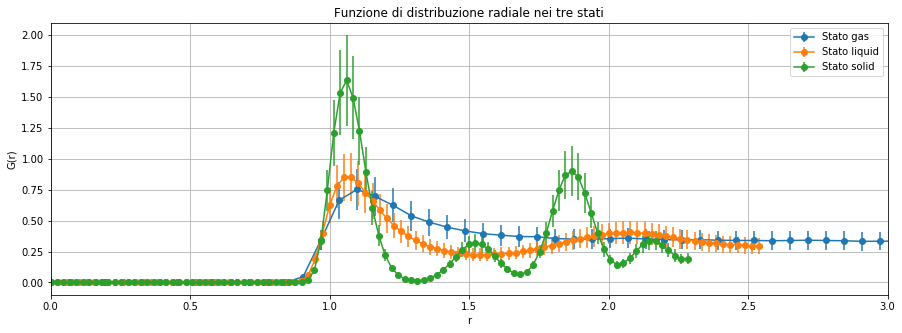

In [152]:

#### Equilibrazione

npart=108
rho=[0.05,0.8,1.1]



fig=plt.figure(figsize=(15, 5))

for j, s in enumerate(['gas','liquid','solid']):
#for j, s in enumerate(['solid']):
    row= np.loadtxt("data03/"+s+"/output_Gr.dat", delimiter=' ', unpack='true',skiprows=19) #Leggo solo l'ultima riga, quella finale
    Gr=[]
    GrError=[]
    row=np.delete(row, 0)
    for i,elem in enumerate(row):
        if i%3==0:
            Gr.append(elem)
        if i%3==2:
            GrError.append(elem)
    scala=((npart/rho[j])**(1/3))/200
    plt.errorbar(scala*np.arange(100),Gr, yerr=GrError, marker="o",label='Stato '+s)
plt.title('Funzione di distribuzione radiale nei tre stati')
plt.xlabel('r')
plt.xlim([0, 3])
plt.ylabel('G(r)')
plt.grid(True)
plt.legend()
plt.show()    

Si osserva, prevedibilmente, che allo stato solido G(r) è una funzione periodica per la sua natura cristallina mentre,  al contrario, nel gas si osserva l'assenza di periodicità dopo un picco iniziale.

Evidenziamo che per tutti gli stati non si trovano particelle al di sotto di una distanza minima, sottolineando la forma divergente del potenziale di LJ.

### Esercizio 07.4

Convertiamo le generiche unità di LJ ad al SI per un sistema di Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu).

Inoltre confrontiamo per ogni stato le **G(r)** ottenute in modalità MC e MD. Queste due modalità rappresentano **sistemi termodinamici differenti (NVE/NVT)** che tuttavia per infinte particelle ci si aspetta siano analoghi, pertanto ci aspettiamo un comportamento sovrapponibile ma non necessariamente *identico*.


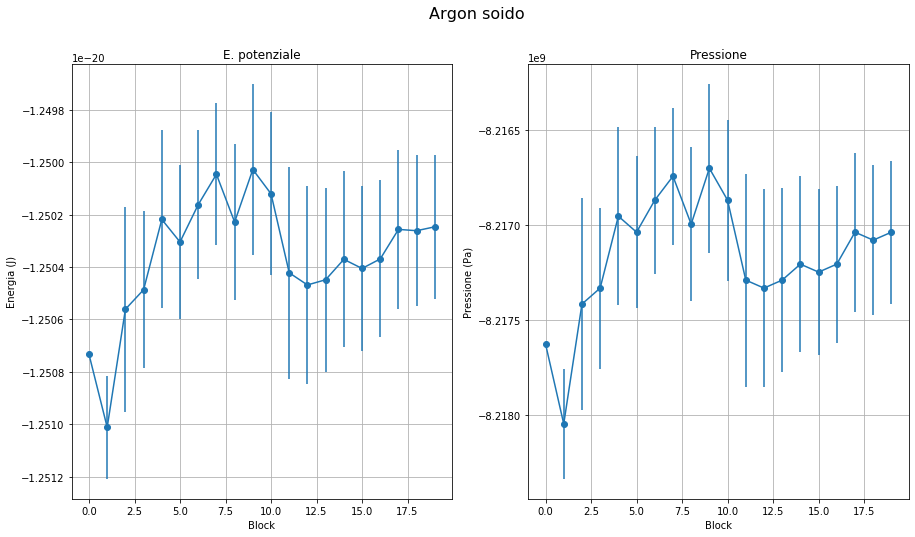

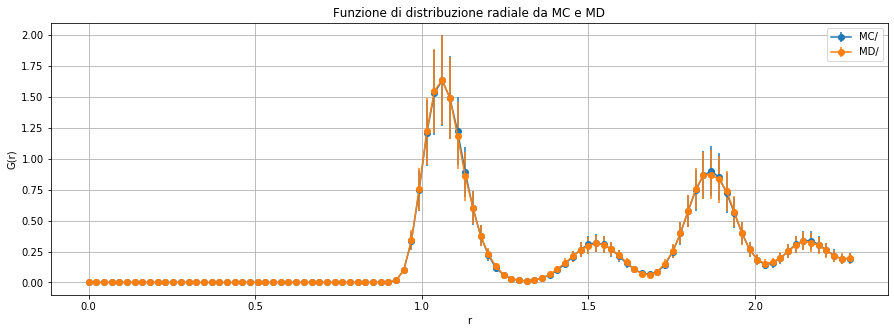

In [153]:
#Preparo per la conversione
kb=1.38064852E-23
sigma=0.34e-09
epsilon=120*kb
presunit=epsilon/sigma**3
#------------------


fig, ax= plt.subplots(1, 2,figsize=(15, 8))
fig.suptitle("Argon soido", fontsize=16)

Epot, Epot_err= np.loadtxt("data04/MC/solid/output_epot.dat", usecols=(2,3), delimiter=' ', unpack='true')
Pres, Pres_err= np.loadtxt("data04/MC/solid/output_pres.dat", usecols=(2,3), delimiter=' ', unpack='true')

ax[0].errorbar(np.arange(20),Epot*epsilon, yerr=Epot_err*epsilon, marker="o")
ax[1].errorbar(np.arange(20),Pres*presunit, yerr=Pres_err*presunit, marker="o",)


ax[0].set_title('E. potenziale')
ax[1].set_title('Pressione')

ax[0].set_xlabel('Block')
ax[1].set_xlabel('Block')


ax[0].set_ylabel('Energia (J)')
ax[1].set_ylabel('Pressione (Pa)')
#ax[0].legend()
#ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)
plt.show()

npart=108
rho=1.1

scala=((npart/rho)**(1/3))/200


fig=plt.figure(figsize=(15, 5))
for mode in ['MC/','MD/']:
    row= np.loadtxt("data04/"+mode+"solid/output_Gr.dat", delimiter=' ', unpack='true',skiprows=19) #Leggo solo l'ultima riga, quella finale
    Gr=[]
    GrError=[]
    row=np.delete(row, 0)
    for i,elem in enumerate(row):
        if i%3==0:
            Gr.append(elem)
        if i%3==2:
            GrError.append(elem)
    plt.errorbar(scala*np.arange(100),Gr, yerr=GrError, marker="o",label=mode)

plt.title('Funzione di distribuzione radiale da MC e MD')
plt.xlabel('r')
plt.ylabel('G(r)')
plt.grid(True)
plt.legend()
plt.show()  

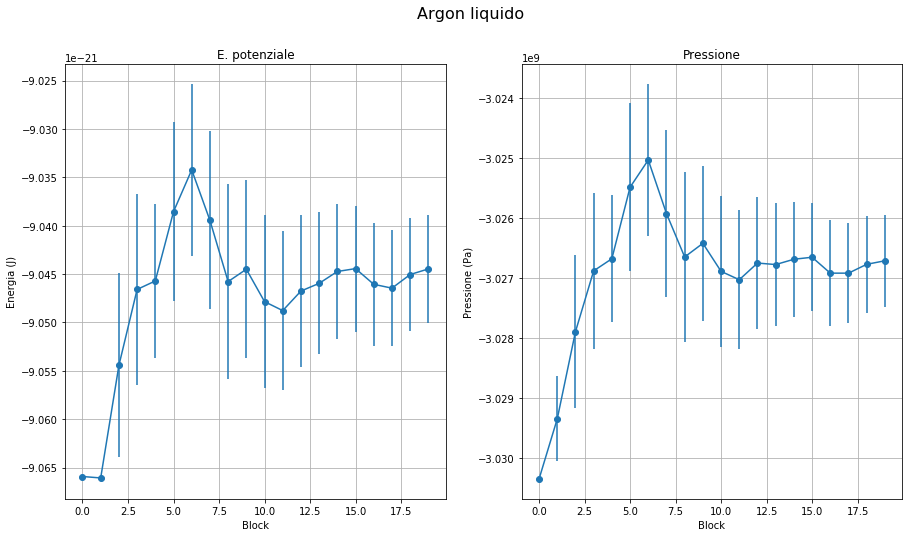

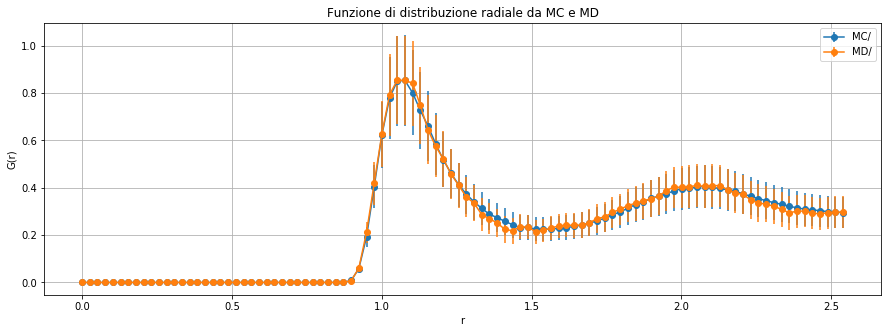

In [157]:

fig, ax= plt.subplots(1, 2,figsize=(15, 8))
fig.suptitle("Argon liquido", fontsize=16)

Epot, Epot_err= np.loadtxt("data04/MC/liquid/output_epot.dat", usecols=(2,3), delimiter=' ', unpack='true')
Pres, Pres_err= np.loadtxt("data04/MC/liquid/output_pres.dat", usecols=(2,3), delimiter=' ', unpack='true')

ax[0].errorbar(np.arange(20),Epot*epsilon, yerr=Epot_err*epsilon, marker="o")
ax[1].errorbar(np.arange(20),Pres*presunit, yerr=Pres_err*presunit, marker="o",)


ax[0].set_title('E. potenziale')
ax[1].set_title('Pressione')

ax[0].set_xlabel('Block')
ax[1].set_xlabel('Block')

ax[0].set_ylabel('Energia (J)')
ax[1].set_ylabel('Pressione (Pa)')

#ax[0].legend()
#ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)
plt.show()

npart=108
rho=0.8

scala=((npart/rho)**(1/3))/200

fig=plt.figure(figsize=(15, 5))
for mode in ['MC/','MD/']:
    row= np.loadtxt("data04/"+mode+"liquid/output_Gr.dat", delimiter=' ', unpack='true',skiprows=19) #Leggo solo l'ultima riga, quella finale
    Gr=[]
    GrError=[]
    row=np.delete(row, 0)
    for i,elem in enumerate(row):
        if i%3==0:
            Gr.append(elem)
        if i%3==2:
            GrError.append(elem)
    plt.errorbar(scala*np.arange(100),Gr, yerr=GrError, marker="o",label=mode)

plt.title('Funzione di distribuzione radiale da MC e MD')
plt.xlabel('r')
plt.ylabel('G(r)')
plt.grid(True)
plt.legend()
plt.show()  

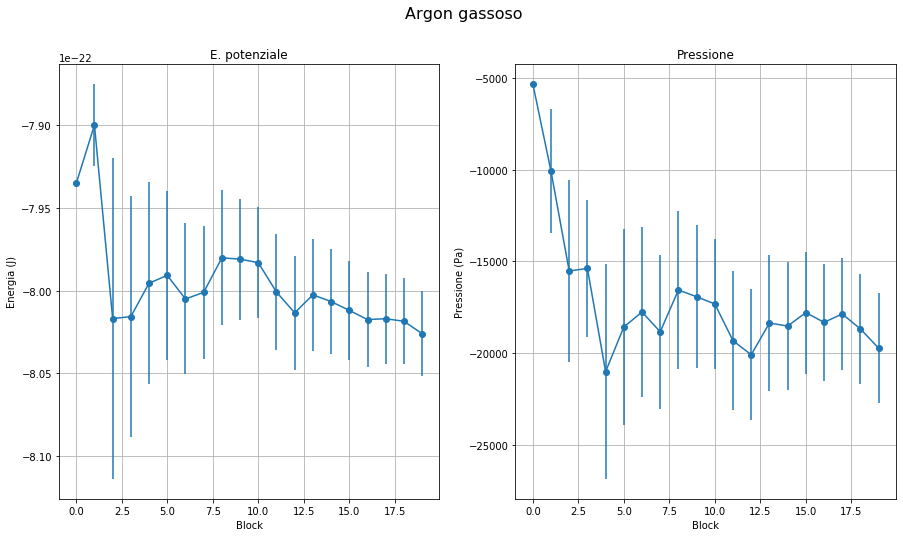

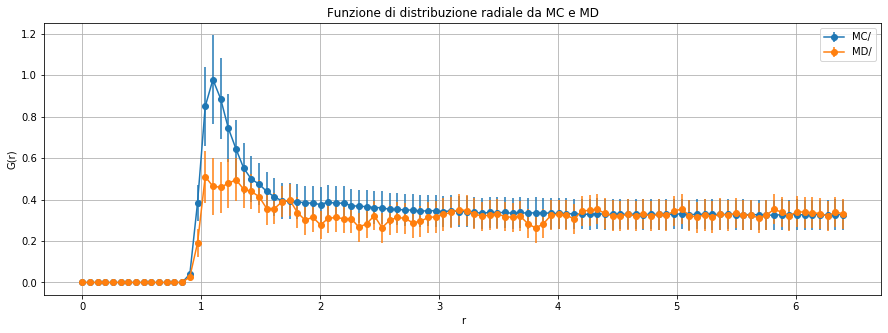

In [155]:

fig, ax= plt.subplots(1, 2,figsize=(15, 8))
fig.suptitle("Argon gassoso", fontsize=16)

Epot, Epot_err= np.loadtxt("data04/MC/gas/output_epot.dat", usecols=(2,3), delimiter=' ', unpack='true')
Pres, Pres_err= np.loadtxt("data04/MC/gas/output_pres.dat", usecols=(2,3), delimiter=' ', unpack='true')

ax[0].errorbar(np.arange(20),Epot*epsilon, yerr=Epot_err*epsilon, marker="o")
ax[1].errorbar(np.arange(20),Pres*presunit, yerr=Pres_err*presunit, marker="o",)


ax[0].set_title('E. potenziale')
ax[1].set_title('Pressione')

ax[0].set_xlabel('Block')
ax[1].set_xlabel('Block')


ax[0].set_ylabel('Energia (J)')
ax[1].set_ylabel('Pressione (Pa)')
#ax[0].legend()
#ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)
plt.show()

npart=108
rho=0.05

scala=((npart/rho)**(1/3))/200

fig=plt.figure(figsize=(15, 5))
for mode in ['MC/','MD/']:
    row= np.loadtxt("data04/"+mode+"gas/output_Gr.dat", delimiter=' ', unpack='true',skiprows=19) #Leggo solo l'ultima riga, quella finale
    Gr=[]
    GrError=[]
    row=np.delete(row, 0)
    for i,elem in enumerate(row):
        if i%3==0:
            Gr.append(elem)
        if i%3==2:
            GrError.append(elem)
    plt.errorbar(scala*np.arange(100),Gr, yerr=GrError, marker="o",label=mode)

plt.title('Funzione di distribuzione radiale da MC e MD')
plt.xlabel('r')
plt.ylabel('G(r)')
plt.grid(True)
plt.legend()
plt.show()  

Le funzioni G(r) si sovrappongono bene ovunque fuorchè nel picco nel caso del gas. Questo punto è critico nella forma del potenziale, pertanto è ragionevole che l'algoritmo di Verlet (che ricordo essere di fatto una espansione in serie) possa essere più impreciso che altrove.